In [ ]:
import pandas as pd
pd.read_csv('C:/ai/source/10_1stProject/수원시 한식 동별 데이터백업.csv')

In [ ]:
 # -*- coding: utf-8 -*-
"""
[C] 날씨 + 요일 + 시간대 + 동 기반 머신러닝 (수원 한식 동별)
- Feature: DONG, DAY(1~7), HOUR(1~10), TEMP, RAIN
- Target: AMT / CNT / UNIT 중 선택
- Split: 최근 test_days일을 테스트로 time-based split (데이터 누수 방지)
- Save/Load: joblib
- Flask 연동용 함수 제공: load_model(), predict_one(), predict_many(), predict_3days_slots()

주의:
- DAY: 1~7 (월~일)
- HOUR: 1~10 (항목요약 슬롯 기준)
"""

import os
import joblib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# =========================
# 경로 설정
# =========================
DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
MODEL_DIR  = r"C:/ai/source/10_1stProject/ml_models_weather"
os.makedirs(MODEL_DIR, exist_ok=True)

FEATURE_CAT = ["DONG", "DAY", "HOUR"]
FEATURE_NUM = ["TEMP", "RAIN"]
FEATURES = FEATURE_CAT + FEATURE_NUM
TARGETS = ["AMT", "CNT", "UNIT"]


# =========================
# 유틸
# =========================
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), 1.0)  # 0 분모 방지
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def ensure_columns(df: pd.DataFrame, cols: list[str]):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"필수 컬럼 누락: {miss}")


# =========================
# 데이터 로드/정리
# =========================
def load_and_clean(csv_path: str = DATA_CSV) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    ensure_columns(df, ["TA_YMD", "DONG", "DAY", "HOUR", "TEMP", "RAIN"])
    for t in TARGETS:
        if t not in df.columns:
            # 타겟 일부가 없는 데이터도 있을 수 있어, 학습 시점에 체크
            pass

    # 날짜
    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    # 숫자 변환
    df["TEMP"] = pd.to_numeric(df["TEMP"], errors="coerce")
    df["RAIN"] = pd.to_numeric(df["RAIN"], errors="coerce")
    df["DAY"]  = pd.to_numeric(df["DAY"], errors="coerce")
    df["HOUR"] = pd.to_numeric(df["HOUR"], errors="coerce")

    # 결측 제거(핵심 피처 + DATE)
    df = df.dropna(subset=["DONG", "DAY", "HOUR", "TEMP", "RAIN", "DATE"]).copy()

    # 범위 방어
    df["DAY"]  = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)
    df = df[df["DAY"].between(1, 7)]
    df = df[df["HOUR"].between(1, 10)]

    # 문자열 정리
    df["DONG"] = df["DONG"].astype(str).str.strip()

    return df


def split_time_based(df: pd.DataFrame, test_days: int = 30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)

    train_df = df[df["DATE"] <= cutoff].copy()
    test_df  = df[df["DATE"] >  cutoff].copy()

    if len(train_df) < 200:
        raise ValueError(f"학습 데이터 부족(train={len(train_df)}). test_days를 줄이거나 데이터 확인.")
    if len(test_df) < 30:
        raise ValueError(f"테스트 데이터 부족(test={len(test_df)}). test_days를 줄이거나 데이터 확인.")

    return train_df, test_df, cutoff, max_date


# =========================
# 모델 파이프라인
# =========================
def build_pipeline(random_state: int = 42) -> Pipeline:
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURE_CAT),
            ("num", "passthrough", FEATURE_NUM),
        ],
        remainder="drop"
    )

    model = RandomForestRegressor(
        n_estimators=700,
        random_state=random_state,
        n_jobs=-1,
        min_samples_leaf=2,
        # max_depth=None  # 필요하면 제한 가능
    )

    return Pipeline([("preprocess", pre), ("model", model)])


# =========================
# 학습/평가/저장
# =========================
def train(target: str = "UNIT", test_days: int = 30, random_state: int = 42):
    if target not in TARGETS:
        raise ValueError(f"target은 {TARGETS} 중 하나여야 합니다.")

    df = load_and_clean(DATA_CSV)
    ensure_columns(df, [target])

    df[target] = pd.to_numeric(df[target], errors="coerce")
    df = df.dropna(subset=[target]).copy()

    train_df, test_df, cutoff, max_date = split_time_based(df, test_days=test_days)

    X_train = train_df[FEATURES]
    y_train = train_df[target].astype(float)

    X_test  = test_df[FEATURES]
    y_test  = test_df[target].astype(float)

    pipe = build_pipeline(random_state=random_state)
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)

    metrics = {
        "target": target,
        "train_rows": int(len(train_df)),
        "test_rows": int(len(test_df)),
        "train_until": str(cutoff.date()),
        "test_range": f"{str((cutoff + pd.Timedelta(days=1)).date())} ~ {str(max_date.date())}",
        "MAE": float(mean_absolute_error(y_test, pred)),
        "RMSE": rmse(y_test, pred),
        "MAPE(%)": mape(y_test, pred),
    }

    model_path = os.path.join(MODEL_DIR, f"rf_{target.lower()}.joblib")
    joblib.dump(pipe, model_path)

    return model_path, metrics


# =========================
# 로드/예측 (Flask에서 그대로 사용)
# =========================
def model_path(target: str) -> str:
    return os.path.join(MODEL_DIR, f"rf_{target.lower()}.joblib")

def load_model(target: str) -> Pipeline:
    p = model_path(target)
    if not os.path.exists(p):
        raise FileNotFoundError(f"모델이 없습니다: {p} (먼저 train() 실행)")
    return joblib.load(p)

def predict_one(target: str, dong: str, day: int, hour: int, temp: float, rain: float) -> float:
    pipe = load_model(target)
    X = pd.DataFrame([{
        "DONG": str(dong).strip(),
        "DAY": int(day),
        "HOUR": int(hour),
        "TEMP": float(temp),
        "RAIN": float(rain),
    }])
    return float(pipe.predict(X)[0])

def predict_many(target: str, rows: list[dict]) -> pd.DataFrame:
    """
    rows 예시:
    [
      {"DONG":"파장동","DAY":3,"HOUR":4,"TEMP":5.3,"RAIN":0.0},
      ...
    ]
    """
    pipe = load_model(target)
    X = pd.DataFrame(rows).copy()
    ensure_columns(X, FEATURES)

    # 타입 정리
    X["DONG"] = X["DONG"].astype(str).str.strip()
    X["DAY"]  = pd.to_numeric(X["DAY"], errors="coerce").astype(int)
    X["HOUR"] = pd.to_numeric(X["HOUR"], errors="coerce").astype(int)
    X["TEMP"] = pd.to_numeric(X["TEMP"], errors="coerce").astype(float)
    X["RAIN"] = pd.to_numeric(X["RAIN"], errors="coerce").astype(float)

    X = X[FEATURES]
    yhat = pipe.predict(X)

    out = X.copy()
    out[f"PRED_{target}"] = yhat
    return out

def predict_3days_slots(target: str, dong: str, start_date_yyyymmdd: str, weather_provider_func):
    """
    Flask에서 자주 쓰는 형태:
    - start_date_yyyymmdd 기준으로 3일치(오늘~+2일) * HOUR 1~10 예측
    - weather_provider_func(date_yyyymmdd, hour_slot) -> (temp, rain)
      * 여기만 기상청 연동으로 바꿔 끼우면 됨.
    """
    base = datetime.strptime(start_date_yyyymmdd, "%Y%m%d")
    rows = []
    for d in range(3):
        dt = base + timedelta(days=d)
        date_str = dt.strftime("%Y%m%d")
        # 요일: 월=1 ... 일=7
        day = (dt.weekday() + 1)

        for hour in range(1, 11):
            temp, rain = weather_provider_func(date_str, hour)
            rows.append({
                "DONG": dong,
                "DAY": day,
                "HOUR": hour,
                "TEMP": float(temp),
                "RAIN": float(rain),
            })

    pred_df = predict_many(target, rows)
    pred_df.insert(0, "DATE", [ (base + timedelta(days=i//10)).strftime("%Y%m%d") for i in range(len(pred_df)) ])
    return pred_df


# =========================
# 실행 예시
# =========================
if __name__ == "__main__":
    # 1) 학습
    p, m = train(target="UNIT", test_days=30)
    print("Saved:", p)
    print("Metrics:", m)

    # 2) 단건 예측
    y = predict_one("UNIT", dong="파장동", day=3, hour=4, temp=5.3, rain=0.0)
    print("PRED_UNIT:", y)

    # 3) 3일치 예측 (날씨함수 예시: 임시로 고정값)
    def dummy_weather(date_yyyymmdd, hour_slot):
        return 5.3, 0.0

    df3 = predict_3days_slots("UNIT", "파장동", "20251231", dummy_weather)
    print(df3.head(15))


In [1]:
# -*- coding: utf-8 -*-
"""
[C-FAST] 동 + 요일 + 시간대 + 날씨 기반 초경량 ML
- 모델: HistGradientBoostingRegressor (빠름, 대용량 친화)
- 인코딩: OrdinalEncoder(카테고리 -> 숫자) (원핫보다 훨씬 가벼움)
- 저장/로드: joblib
"""

import os
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
MODEL_DIR  = r"C:/ai/source/10_1stProject/ml_models_weather"
os.makedirs(MODEL_DIR, exist_ok=True)

FEATURE_CAT = ["DONG", "DAY", "HOUR"]
FEATURE_NUM = ["TEMP", "RAIN"]
FEATURES = FEATURE_CAT + FEATURE_NUM
TARGETS = ["AMT", "CNT", "UNIT"]

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def load_clean():
    df = pd.read_csv(DATA_CSV)

    # 날짜
    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    # 타입 정리
    df["DONG"] = df["DONG"].astype(str).str.strip()
    for c in ["DAY", "HOUR", "TEMP", "RAIN"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["DATE", "DONG", "DAY", "HOUR", "TEMP", "RAIN"]).copy()

    # 범위 방어
    df["DAY"] = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)
    df = df[df["DAY"].between(1, 7)]
    df = df[df["HOUR"].between(1, 10)]

    return df

def time_split(df, test_days=30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)
    train_df = df[df["DATE"] <= cutoff].copy()
    test_df  = df[df["DATE"] >  cutoff].copy()
    return train_df, test_df, cutoff, max_date

def build_pipe():
    # 카테고리: 결측 채우고 -> Ordinal encoding
    cat_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ])

    # 숫자: 결측 0으로
    num_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("cat", cat_tf, FEATURE_CAT),
            ("num", num_tf, FEATURE_NUM),
        ],
        remainder="drop"
    )

    # 초경량 모델
    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.08,
        max_iter=300,        # 반복 수(많을수록 성능↑, 시간↑)
        random_state=42
    )

    return Pipeline([("pre", pre), ("model", model)])

def train(target="UNIT", test_days=30):
    if target not in TARGETS:
        raise ValueError(f"target은 {TARGETS} 중 하나")

    df = load_clean()
    if target not in df.columns:
        raise ValueError(f"데이터에 {target} 컬럼이 없습니다.")

    df[target] = pd.to_numeric(df[target], errors="coerce")
    df = df.dropna(subset=[target]).copy()

    train_df, test_df, cutoff, max_date = time_split(df, test_days=test_days)

    X_train, y_train = train_df[FEATURES], train_df[target].astype(float)
    X_test,  y_test  = test_df[FEATURES],  test_df[target].astype(float)

    pipe = build_pipe()
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)

    metrics = {
        "target": target,
        "train_rows": int(len(train_df)),
        "test_rows": int(len(test_df)),
        "train_until": str(cutoff.date()),
        "test_to": str(max_date.date()),
        "MAE": float(mean_absolute_error(y_test, pred)),
        "RMSE": rmse(y_test, pred),
    }

    path = os.path.join(MODEL_DIR, f"hgb_{target.lower()}.joblib")
    joblib.dump(pipe, path)
    return path, metrics

def load_model(target="UNIT"):
    path = os.path.join(MODEL_DIR, f"hgb_{target.lower()}.joblib")
    if not os.path.exists(path):
        raise FileNotFoundError(f"모델 없음: {path} (train 먼저)")
    return joblib.load(path)

def predict_one(target, dong, day, hour, temp, rain):
    pipe = load_model(target)
    X = pd.DataFrame([{
        "DONG": str(dong).strip(),
        "DAY": int(day),
        "HOUR": int(hour),
        "TEMP": float(temp),
        "RAIN": float(rain),
    }])
    return float(pipe.predict(X)[0])

if __name__ == "__main__":
    model_path, metrics = train(target="UNIT", test_days=30)
    print("Saved:", model_path)
    print("Metrics:", metrics)

    y = predict_one("UNIT", "파장동", 3, 4, 5.3, 0.0)
    print("PRED_UNIT:", y)


Saved: C:/ai/source/10_1stProject/ml_models_weather\hgb_unit.joblib
Metrics: {'target': 'UNIT', 'train_rows': 430697, 'test_rows': 12826, 'train_until': '2025-10-01', 'test_to': '2025-10-31', 'MAE': 10984.93262733055, 'RMSE': 40849.3860485607}
PRED_UNIT: 27440.276018547054


In [4]:
# -*- coding: utf-8 -*-
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# 설정
# =========================
DATA_CSV   = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
MODEL_PATH = r"C:/ai/source/10_1stProject/ml_models_weather/hgb_unit.joblib"  # <- 네 AMT 모델 경로로 수정
OUT_DIR    = r"C:/ai/source/10_1stProject/eval_amt_weather_combo"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET   = "AMT"
FEATURES = ["DONG", "DAY", "HOUR", "TEMP", "RAIN"]

# 비 기준: 0 초과면 비로 간주 (필요시 0.1로 올려도 됨)
RAIN_THRESHOLD = 0.0

# 온도 구간(원하면 여기만 바꾸면 끝)
TEMP_BINS = [-50, 0, 5, 10, 15, 20, 25, 30, 50]

# 조합별 표본이 너무 적으면 제외
MIN_N = 80

# 테스트 분리(최근 N일)
TEST_DAYS = 30


# =========================
# metrics
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), 1.0)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, 1.0)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)

def compute_metrics(y_true, y_pred):
    _mape = mape(y_true, y_pred)
    return {
        "N": int(len(y_true)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "MAPE(%)": _mape,
        "sMAPE(%)": smape(y_true, y_pred),
        "Accuracy%(=100-MAPE)": float(max(0.0, 100.0 - _mape)),
        "R2": float(r2_score(y_true, y_pred)) if len(y_true) >= 2 else np.nan,
    }


# =========================
# data
# =========================
def load_clean():
    df = pd.read_csv(DATA_CSV)

    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    df["DONG"] = df["DONG"].astype(str).str.strip()
    for c in ["DAY", "HOUR", "TEMP", "RAIN", TARGET]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
    df["DAY"]  = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)

    df = df[df["DAY"].between(1,7)]
    df = df[df["HOUR"].between(1,10)]
    return df

def time_split(df, test_days=30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)
    test_df = df[df["DATE"] > cutoff].copy()
    return test_df, cutoff, max_date


# =========================
# labels + group eval
# =========================
def add_weather_combo(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    out["RAIN_FLAG"] = np.where(out["RAIN"] > RAIN_THRESHOLD, "RAINY", "NO_RAIN")
    out["TEMP_BIN"] = pd.cut(out["TEMP"], bins=TEMP_BINS, include_lowest=True)
    out["TEMP_BIN"] = out["TEMP_BIN"].astype(str)

    out["WEATHER_COMBO"] = out["TEMP_BIN"] + "_" + out["RAIN_FLAG"]
    return out

def eval_by_combo(df: pd.DataFrame, min_n=80) -> pd.DataFrame:
    rows = []
    for k, g in df.groupby("WEATHER_COMBO"):
        if len(g) < min_n:
            continue
        met = compute_metrics(g[TARGET].values, g["PRED"].values)
        met["WEATHER_COMBO"] = k
        rows.append(met)

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out

    out = out.sort_values("Accuracy%(=100-MAPE)", ascending=False).reset_index(drop=True)
    return out


# =========================
# plot
# =========================
def save_bar_rank(df, path, title, top_n=25, ascending=False):
    """
    ascending=False => 상위(Accuracy 높은) 랭킹
    ascending=True  => 하위(Accuracy 낮은) 랭킹
    """
    d = df.sort_values("Accuracy%(=100-MAPE)", ascending=ascending).head(top_n).copy()
    plt.figure(figsize=(12, 4))
    plt.bar(d["WEATHER_COMBO"].astype(str), d["Accuracy%(=100-MAPE)"].astype(float))
    plt.xticks(rotation=70, ha="right")
    plt.xlabel("WEATHER_COMBO (TEMP bin x RAIN)")
    plt.ylabel("Accuracy% (100 - MAPE)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=180)
    plt.close()


# =========================
# main
# =========================
def run():
    df = load_clean()
    test_df, cutoff, max_date = time_split(df, test_days=TEST_DAYS)

    pipe = joblib.load(MODEL_PATH)

    X = test_df[FEATURES]
    y_pred = pipe.predict(X)

    out = test_df[["DATE","TA_YMD","DONG","DAY","HOUR","TEMP","RAIN",TARGET]].copy()
    out["PRED"] = y_pred

    out = add_weather_combo(out)

    overall = compute_metrics(out[TARGET].values, out["PRED"].values)
    by_combo = eval_by_combo(out, min_n=MIN_N)

    # 저장
    pd.DataFrame([overall]).to_csv(os.path.join(OUT_DIR, "overall_amt.csv"), index=False, encoding="utf-8-sig")
    out.to_csv(os.path.join(OUT_DIR, "pred_table_amt.csv"), index=False, encoding="utf-8-sig")
    by_combo.to_csv(os.path.join(OUT_DIR, "by_weather_combo_amt.csv"), index=False, encoding="utf-8-sig")

    # 그래프(상위/하위)
    if len(by_combo) > 0:
        save_bar_rank(by_combo, os.path.join(OUT_DIR, "top_accuracy_weather_combo.png"),
                      title="TOP Weather Combo Accuracy% (AMT) [100-MAPE]", top_n=25, ascending=False)
        save_bar_rank(by_combo, os.path.join(OUT_DIR, "worst_accuracy_weather_combo.png"),
                      title="WORST Weather Combo Accuracy% (AMT) [100-MAPE]", top_n=25, ascending=True)

    print("=== DONE ===")
    print("Test range:", str((cutoff + pd.Timedelta(days=1)).date()), "~", str(max_date.date()))
    print("Overall:", overall)
    print("Saved:", OUT_DIR)
    print("Combo rows:", len(by_combo))

if __name__ == "__main__":
    run()


=== DONE ===
Test range: 2025-10-02 ~ 2025-10-31
Overall: {'N': 12826, 'MAE': 5501451.001779406, 'RMSE': 15244490.83434509, 'MAPE(%)': 99.26763149395299, 'sMAPE(%)': 181.62628573390563, 'Accuracy%(=100-MAPE)': 0.7323685060470098, 'R2': -0.14931998705896832}
Saved: C:/ai/source/10_1stProject/eval_amt_weather_combo
Combo rows: 8


In [5]:
import os, joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import ParameterGrid


DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
OUT_DIR  = r"C:/ai/source/10_1stProject/models_weather_C_fast_v2"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET = "AMT"
CAT = ["DONG","DAY","HOUR"]
NUM = ["TEMP","RAIN","RAIN_FLAG","TEMP2","HOUR_SIN","HOUR_COS"]
FEATURES = CAT + NUM

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), 1.0)
    return float(np.mean(np.abs((y_true-y_pred)/denom))*100)

def acc100(y_true, y_pred):
    return max(0.0, 100.0 - mape(y_true, y_pred))

def load_clean():
    df = pd.read_csv(DATA_CSV)
    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")
    df["DONG"] = df["DONG"].astype(str).str.strip()

    for c in ["DAY","HOUR","TEMP","RAIN",TARGET]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
    df["DAY"]  = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)
    df = df[df["DAY"].between(1,7)]
    df = df[df["HOUR"].between(1,10)]

    # 가벼운 피처 엔지니어링
    df["RAIN_FLAG"] = (df["RAIN"] > 0).astype(int)
    df["TEMP2"] = df["TEMP"] ** 2
    df["HOUR_SIN"] = np.sin(2*np.pi*df["HOUR"]/10)
    df["HOUR_COS"] = np.cos(2*np.pi*df["HOUR"]/10)

    return df

def time_split(df, test_days=30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)
    train = df[df["DATE"] <= cutoff].copy()
    test  = df[df["DATE"] >  cutoff].copy()
    return train, test

def build_pipe(model):
    cat_tf = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ])
    num_tf = Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value=0.0)),
    ])
    pre = ColumnTransformer([
        ("cat", cat_tf, CAT),
        ("num", num_tf, NUM),
    ])
    return Pipeline([("pre", pre), ("model", model)])

def tune_small():
    df = load_clean()
    train_df, test_df = time_split(df, test_days=30)

    X_train, y_train = train_df[FEATURES], train_df[TARGET].astype(float)
    X_test,  y_test  = test_df[FEATURES],  test_df[TARGET].astype(float)

    grid = ParameterGrid({
        "max_depth": [8, 10],
        "learning_rate": [0.08, 0.06],
        "max_iter": [300, 500],
        "min_samples_leaf": [20, 40],
        "l2_regularization": [0.0, 0.1],
    })

    best = None
    for params in grid:
        model = HistGradientBoostingRegressor(
            random_state=42,
            **params
        )
        pipe = build_pipe(model)
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        acc = acc100(y_test, pred)
        row = {"acc100": acc, "mape": mape(y_test, pred), **params}
        print(row)

        if (best is None) or (acc > best["acc100"]):
            best = row
            joblib.dump(pipe, os.path.join(OUT_DIR, "best_hgb_amt.joblib"))

    print("=== BEST ===")
    print(best)
    return best

if __name__ == "__main__":
    tune_small()


{'acc100': 0.0, 'mape': 215.48902203710415, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 8, 'max_iter': 300, 'min_samples_leaf': 20}
{'acc100': 0.0, 'mape': 203.11862406228295, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 8, 'max_iter': 300, 'min_samples_leaf': 40}
{'acc100': 0.0, 'mape': 204.97233111423694, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 8, 'max_iter': 500, 'min_samples_leaf': 20}
{'acc100': 0.0, 'mape': 180.01732824880952, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 8, 'max_iter': 500, 'min_samples_leaf': 40}
{'acc100': 0.0, 'mape': 259.31642828487344, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 20}
{'acc100': 0.0, 'mape': 249.33020016091888, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 40}
{'acc100': 0.0, 'mape': 259.31642828487344, 'l2_regularization': 0.0, 'learning_rate': 0.08, 'max_

X_train shape: (310466, 48) X_test shape: (133057, 48)
Epoch 1/200
971/971 - 2s - loss: 125849923747840.0000 - mae: 4639729.0000 - val_loss: 110771694469120.0000 - val_mae: 4488249.0000 - 2s/epoch - 2ms/step
Epoch 2/200
971/971 - 2s - loss: 87777580417024.0000 - mae: 4067550.7500 - val_loss: 84871137460224.0000 - val_mae: 3737268.2500 - 2s/epoch - 2ms/step
Epoch 3/200
971/971 - 2s - loss: 72903211089920.0000 - mae: 3704553.2500 - val_loss: 78965783920640.0000 - val_mae: 3621848.5000 - 2s/epoch - 2ms/step
Epoch 4/200
971/971 - 2s - loss: 70968814862336.0000 - mae: 3659270.2500 - val_loss: 78180475994112.0000 - val_mae: 3589714.5000 - 2s/epoch - 2ms/step
Epoch 5/200
971/971 - 2s - loss: 70444526862336.0000 - mae: 3643949.2500 - val_loss: 77563149942784.0000 - val_mae: 3571935.5000 - 2s/epoch - 2ms/step
Epoch 6/200
971/971 - 2s - loss: 69925662097408.0000 - mae: 3626372.0000 - val_loss: 76962726936576.0000 - val_mae: 3560110.2500 - 2s/epoch - 2ms/step
Epoch 7/200
971/971 - 2s - loss: 6937

Epoch 55/200
971/971 - 2s - loss: 45740617367552.0000 - mae: 2562985.5000 - val_loss: 51995268349952.0000 - val_mae: 2519247.2500 - 2s/epoch - 2ms/step
Epoch 56/200
971/971 - 2s - loss: 45141708505088.0000 - mae: 2534228.0000 - val_loss: 51349165178880.0000 - val_mae: 2478483.7500 - 2s/epoch - 2ms/step
Epoch 57/200
971/971 - 2s - loss: 44557337100288.0000 - mae: 2505646.0000 - val_loss: 50714671841280.0000 - val_mae: 2449621.2500 - 2s/epoch - 2ms/step
Epoch 58/200
971/971 - 2s - loss: 43958747004928.0000 - mae: 2473893.0000 - val_loss: 50179453485056.0000 - val_mae: 2403343.5000 - 2s/epoch - 2ms/step
Epoch 59/200
971/971 - 2s - loss: 43318889152512.0000 - mae: 2441181.0000 - val_loss: 49397408727040.0000 - val_mae: 2387874.5000 - 2s/epoch - 2ms/step
Epoch 60/200
971/971 - 2s - loss: 42617102401536.0000 - mae: 2404191.2500 - val_loss: 48667419475968.0000 - val_mae: 2369169.2500 - 2s/epoch - 2ms/step
Epoch 61/200
971/971 - 2s - loss: 41862664552448.0000 - mae: 2365442.2500 - val_loss: 47

Epoch 109/200
971/971 - 2s - loss: 28634777649152.0000 - mae: 1653925.8750 - val_loss: 34479244574720.0000 - val_mae: 1645031.1250 - 2s/epoch - 2ms/step
Epoch 110/200
971/971 - 2s - loss: 28536471552000.0000 - mae: 1647323.0000 - val_loss: 34487090020352.0000 - val_mae: 1644902.6250 - 2s/epoch - 2ms/step
Epoch 111/200
971/971 - 2s - loss: 28434537381888.0000 - mae: 1645647.7500 - val_loss: 34387194281984.0000 - val_mae: 1617136.6250 - 2s/epoch - 2ms/step
Epoch 112/200
971/971 - 2s - loss: 28348971483136.0000 - mae: 1640768.1250 - val_loss: 34257546248192.0000 - val_mae: 1646268.8750 - 2s/epoch - 2ms/step
Epoch 113/200
971/971 - 2s - loss: 28244889829376.0000 - mae: 1636960.0000 - val_loss: 34092036915200.0000 - val_mae: 1626472.3750 - 2s/epoch - 2ms/step
Epoch 114/200
971/971 - 2s - loss: 28156822028288.0000 - mae: 1631840.3750 - val_loss: 34097229463552.0000 - val_mae: 1599771.3750 - 2s/epoch - 2ms/step
Epoch 115/200
971/971 - 2s - loss: 28082767396864.0000 - mae: 1625993.6250 - val_l

Epoch 163/200
971/971 - 2s - loss: 25311173410816.0000 - mae: 1500577.3750 - val_loss: 31391999852544.0000 - val_mae: 1480722.5000 - 2s/epoch - 2ms/step
Epoch 164/200
971/971 - 2s - loss: 25291504222208.0000 - mae: 1497412.2500 - val_loss: 31306486382592.0000 - val_mae: 1479519.5000 - 2s/epoch - 2ms/step
Epoch 165/200
971/971 - 2s - loss: 25268278263808.0000 - mae: 1497599.1250 - val_loss: 31298691268608.0000 - val_mae: 1517694.0000 - 2s/epoch - 2ms/step
Epoch 166/200
971/971 - 2s - loss: 25229749387264.0000 - mae: 1495221.7500 - val_loss: 31228593963008.0000 - val_mae: 1512428.6250 - 2s/epoch - 2ms/step
Epoch 167/200
971/971 - 2s - loss: 25199571369984.0000 - mae: 1492856.1250 - val_loss: 31242311434240.0000 - val_mae: 1492811.6250 - 2s/epoch - 2ms/step
Epoch 168/200
971/971 - 2s - loss: 25146777665536.0000 - mae: 1489183.3750 - val_loss: 31193384878080.0000 - val_mae: 1471614.2500 - 2s/epoch - 2ms/step
Epoch 169/200
971/971 - 2s - loss: 25117270736896.0000 - mae: 1492723.3750 - val_l

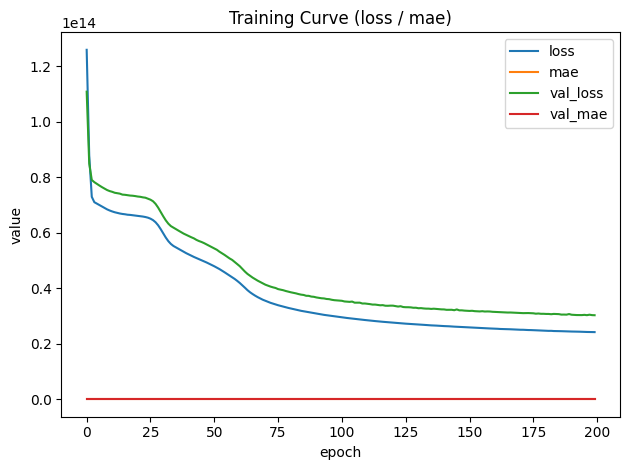

In [10]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
TARGET = "AMT"

# -------------------------
# 1) 데이터 로드/정리
# -------------------------
df = pd.read_csv(DATA_CSV)

df["TA_YMD"] = df["TA_YMD"].astype(str)
df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

df["DONG"] = df["DONG"].astype(str).str.strip()
for c in ["DAY", "HOUR", "TEMP", "RAIN", TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
df["DAY"]  = df["DAY"].astype(int)
df["HOUR"] = df["HOUR"].astype(int)
df = df[df["DAY"].between(1,7)]
df = df[df["HOUR"].between(1,10)]

# (옵션) AMT 너무 큰 값 때문에 학습 불안정하면 로그 타겟이 더 잘 먹힘
# y = np.log1p(df[TARGET].values)  # <- 이거 켜면 아래 inverse도 해야 함
y = df[TARGET].astype(float).values

X = df[["DONG","DAY","HOUR","TEMP","RAIN"]].copy()

# -------------------------
# 2) 전처리: DONG 원핫 + 나머지 스케일
# -------------------------
cat_cols = ["DONG"]
num_cols = ["DAY","HOUR","TEMP","RAIN"]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 전처리 fit/transform
X_train_t = pre.fit_transform(X_train)
X_test_t  = pre.transform(X_test)

# sparse -> dense (Keras는 dense가 편함)
# (피처 수가 너무 많으면 dense가 무거울 수 있음. 그때는 OrdinalEncoder로 바꿔줄게.)
X_train_t = X_train_t.toarray() if hasattr(X_train_t, "toarray") else np.asarray(X_train_t)
X_test_t  = X_test_t.toarray()  if hasattr(X_test_t, "toarray")  else np.asarray(X_test_t)

print("X_train shape:", X_train_t.shape, "X_test shape:", X_test_t.shape)

# -------------------------
# 3) 모델 만들기 (가벼운 MLP)
# -------------------------
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train_t.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  # 회귀
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

# EarlyStopping: 너무 오래 안 돌게 + 최고 성능 가중치 복원
cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# -------------------------
# 4) 학습 (스샷처럼 로그 출력)
# -------------------------
hist = model.fit(
    X_train_t, y_train,
    validation_split=0.2,
    epochs=200,      # 스샷처럼 1000도 가능하지만, 보통 earlystop이면 200이면 충분
    batch_size=256,
    verbose=2,       # ✅ 스샷처럼 epoch 로그 출력
    callbacks=[cb]
)

# -------------------------
# 5) 평가 + 그래프 (스샷처럼 loss/mae)
# -------------------------
test_loss, test_mae = model.evaluate(X_test_t, y_test, verbose=0)
print(f"[TEST] loss(mse)={test_loss:.4f}  mae={test_mae:.4f}")

plt.figure()
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["mae"], label="mae")
if "val_loss" in hist.history:
    plt.plot(hist.history["val_loss"], label="val_loss")
if "val_mae" in hist.history:
    plt.plot(hist.history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.title("Training Curve (loss / mae)")
plt.tight_layout()
plt.show()


X_train shape: (310466, 48) X_test shape: (133057, 48)
Epoch 1/200
971/971 - 3s - loss: 94040942968832.0000 - mae: 4174123.2500 - val_loss: 78039396384768.0000 - val_mae: 3591751.0000 - 3s/epoch - 3ms/step
Epoch 2/200
971/971 - 3s - loss: 69663639732224.0000 - mae: 3630542.2500 - val_loss: 75851118936064.0000 - val_mae: 3565985.5000 - 3s/epoch - 3ms/step
Epoch 3/200
971/971 - 3s - loss: 68011402723328.0000 - mae: 3583165.0000 - val_loss: 74627934060544.0000 - val_mae: 3491969.2500 - 3s/epoch - 3ms/step
Epoch 4/200
971/971 - 3s - loss: 67041604141056.0000 - mae: 3556980.5000 - val_loss: 73726804623360.0000 - val_mae: 3492851.5000 - 3s/epoch - 3ms/step
Epoch 5/200
971/971 - 3s - loss: 66365935321088.0000 - mae: 3544139.7500 - val_loss: 73321542582272.0000 - val_mae: 3460527.5000 - 3s/epoch - 3ms/step
Epoch 6/200
971/971 - 3s - loss: 65310908481536.0000 - mae: 3510669.2500 - val_loss: 70964377288704.0000 - val_mae: 3418663.0000 - 3s/epoch - 3ms/step
Epoch 7/200
971/971 - 3s - loss: 612236

Epoch 55/200
971/971 - 3s - loss: 22984095956992.0000 - mae: 1387801.8750 - val_loss: 28764499083264.0000 - val_mae: 1359736.0000 - 3s/epoch - 3ms/step
Epoch 56/200
971/971 - 3s - loss: 22932979974144.0000 - mae: 1381434.8750 - val_loss: 29478789054464.0000 - val_mae: 1400527.2500 - 3s/epoch - 3ms/step
Epoch 57/200
971/971 - 3s - loss: 22972018458624.0000 - mae: 1383216.6250 - val_loss: 28896726614016.0000 - val_mae: 1354471.7500 - 3s/epoch - 3ms/step
Epoch 58/200
971/971 - 3s - loss: 23016622784512.0000 - mae: 1377592.1250 - val_loss: 28642956541952.0000 - val_mae: 1381293.6250 - 3s/epoch - 3ms/step
Epoch 59/200
971/971 - 3s - loss: 22886035226624.0000 - mae: 1379630.2500 - val_loss: 29240250597376.0000 - val_mae: 1362114.8750 - 3s/epoch - 3ms/step
Epoch 60/200
971/971 - 3s - loss: 22809411584000.0000 - mae: 1374041.0000 - val_loss: 28753398857728.0000 - val_mae: 1419039.5000 - 3s/epoch - 3ms/step
Epoch 61/200
971/971 - 3s - loss: 22861783760896.0000 - mae: 1374770.6250 - val_loss: 28

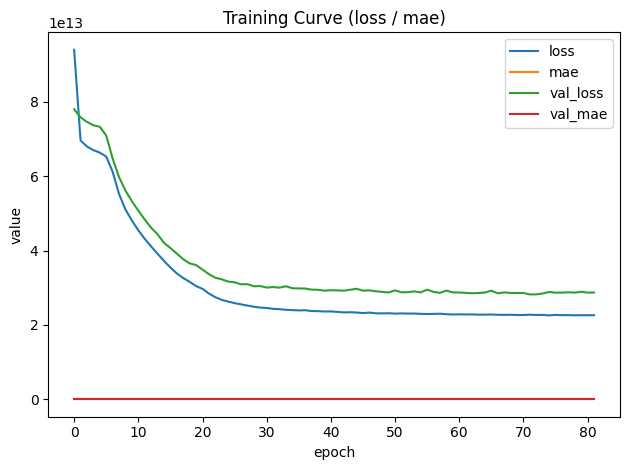

In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
TARGET = "AMT"

# -------------------------
# 1) 데이터 로드/정리
# -------------------------
df = pd.read_csv(DATA_CSV)

df["TA_YMD"] = df["TA_YMD"].astype(str)
df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

df["DONG"] = df["DONG"].astype(str).str.strip()
for c in ["DAY", "HOUR", "TEMP", "RAIN", TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
df["DAY"]  = df["DAY"].astype(int)
df["HOUR"] = df["HOUR"].astype(int)
df = df[df["DAY"].between(1,7)]
df = df[df["HOUR"].between(1,10)]

# (옵션) AMT 너무 큰 값 때문에 학습 불안정하면 로그 타겟이 더 잘 먹힘
# y = np.log1p(df[TARGET].values)  # <- 이거 켜면 아래 inverse도 해야 함
y = df[TARGET].astype(float).values

X = df[["DONG","DAY","HOUR","TEMP","RAIN"]].copy()

# -------------------------
# 2) 전처리: DONG 원핫 + 나머지 스케일
# -------------------------
cat_cols = ["DONG"]
num_cols = ["DAY","HOUR","TEMP","RAIN"]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 전처리 fit/transform
X_train_t = pre.fit_transform(X_train)
X_test_t  = pre.transform(X_test)

# sparse -> dense (Keras는 dense가 편함)
# (피처 수가 너무 많으면 dense가 무거울 수 있음. 그때는 OrdinalEncoder로 바꿔줄게.)
X_train_t = X_train_t.toarray() if hasattr(X_train_t, "toarray") else np.asarray(X_train_t)
X_test_t  = X_test_t.toarray()  if hasattr(X_test_t, "toarray")  else np.asarray(X_test_t)

print("X_train shape:", X_train_t.shape, "X_test shape:", X_test_t.shape)

# -------------------------
# 3) 모델 만들기 (가벼운 MLP)
# -------------------------
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train_t.shape[1],)),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  # 회귀
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

# EarlyStopping: 너무 오래 안 돌게 + 최고 성능 가중치 복원
cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# -------------------------
# 4) 학습 (스샷처럼 로그 출력)
# -------------------------
hist = model.fit(
    X_train_t, y_train,
    validation_split=0.2,
    epochs=200,      # 스샷처럼 1000도 가능하지만, 보통 earlystop이면 200이면 충분
    batch_size=256,
    verbose=2,       # ✅ 스샷처럼 epoch 로그 출력
    callbacks=[cb]
)

# -------------------------
# 5) 평가 + 그래프 (스샷처럼 loss/mae)
# -------------------------
test_loss, test_mae = model.evaluate(X_test_t, y_test, verbose=0)
print(f"[TEST] loss(mse)={test_loss:.4f}  mae={test_mae:.4f}")

plt.figure()
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["mae"], label="mae")
if "val_loss" in hist.history:
    plt.plot(hist.history["val_loss"], label="val_loss")
if "val_mae" in hist.history:
    plt.plot(hist.history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.title("Training Curve (loss / mae)")
plt.tight_layout()
plt.show()


In [4]:
# -*- coding: utf-8 -*-
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# 경로 설정(너 환경에 맞게 수정)
# =========================
DATA_CSV   = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
RF_PATH    = r"C:/ai/source/10_1stProject/models_weather_C/rf_amt.joblib"            # 없으면 ""로 두기
HGB_PATH   = r"C:/ai/source/10_1stProject/models_weather_C_fast/hgb_amt.joblib"      # 없으면 ""로 두기
OUT_DIR    = r"C:/ai/source/10_1stProject/compare_models_amt"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET   = "AMT"
FEATURES = ["DONG", "DAY", "HOUR", "TEMP", "RAIN"]

# 딥러닝 학습 설정(가볍게)
DEEP_EPOCHS = 80
DEEP_BATCH  = 256
DEEP_VERBOSE = 0  # 비교평가라 로그 끄는게 편함(원하면 2로)

# =========================
# metrics (Accuracy = 100 - MAPE)
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), 1.0)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def acc100(y_true, y_pred):
    return float(max(0.0, 100.0 - mape(y_true, y_pred)))

def metrics_all(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "MAPE(%)": float(mape(y_true, y_pred)),
        "Accuracy%(=100-MAPE)": float(acc100(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)) if len(y_true) >= 2 else np.nan
    }

# =========================
# data load + clean + time split
# =========================
def load_clean():
    df = pd.read_csv(DATA_CSV)
    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    df["DONG"] = df["DONG"].astype(str).str.strip()
    for c in ["DAY","HOUR","TEMP","RAIN",TARGET]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
    df["DAY"]  = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)
    df = df[df["DAY"].between(1,7)]
    df = df[df["HOUR"].between(1,10)]
    return df

def time_split(df, test_days=30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)
    train_df = df[df["DATE"] <= cutoff].copy()
    test_df  = df[df["DATE"] >  cutoff].copy()
    return train_df, test_df, cutoff, max_date

# =========================
# deep model (학습 후 예측)
# =========================
def build_pre_for_deep():
    pre = ColumnTransformer(
        transformers=[
            ("dong", OneHotEncoder(handle_unknown="ignore"), ["DONG"]),
            ("num", StandardScaler(), ["DAY","HOUR","TEMP","RAIN"]),
        ],
        remainder="drop"
    )
    return pre

def train_and_predict_deep(X_train_df, y_train, X_test_df, seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    pre = build_pre_for_deep()
    Xtr = pre.fit_transform(X_train_df)
    Xte = pre.transform(X_test_df)

    Xtr = Xtr.toarray() if hasattr(Xtr, "toarray") else np.asarray(Xtr)
    Xte = Xte.toarray() if hasattr(Xte, "toarray") else np.asarray(Xte)

    model = keras.Sequential([
        layers.Input(shape=(Xtr.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])

    model.fit(Xtr, y_train, epochs=DEEP_EPOCHS, batch_size=DEEP_BATCH, verbose=DEEP_VERBOSE)

    pred = model.predict(Xte, verbose=0).reshape(-1)
    # (옵션) 딥러닝 모델 저장하고 싶으면 아래 주석 해제
    # model.save(os.path.join(OUT_DIR, "deep_amt.keras"))
    return pred

# =========================
# plot helpers
# =========================
def save_bar_compare(df_metrics, metric_name, path):
    plt.figure()
    plt.bar(df_metrics["Model"], df_metrics[metric_name].astype(float))
    plt.xlabel("Model")
    plt.ylabel(metric_name)
    plt.title(f"Model Comparison - {metric_name} (AMT)")
    plt.tight_layout()
    plt.savefig(path, dpi=180)
    plt.close()

# =========================
# main compare
# =========================
def run_compare(test_days=30):
    df = load_clean()
    train_df, test_df, cutoff, max_date = time_split(df, test_days=test_days)

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET].astype(float).values
    X_test  = test_df[FEATURES]
    y_test  = test_df[TARGET].astype(float).values

    results = []

    # RF (joblib Pipeline)
    if RF_PATH and os.path.exists(RF_PATH):
        rf = joblib.load(RF_PATH)
        pred_rf = rf.predict(X_test)
        met = metrics_all(y_test, pred_rf)
        met["Model"] = "RF"
        results.append(met)

    # HGB (joblib Pipeline)
    if HGB_PATH and os.path.exists(HGB_PATH):
        hgb = joblib.load(HGB_PATH)
        pred_hgb = hgb.predict(X_test)
        met = metrics_all(y_test, pred_hgb)
        met["Model"] = "HGB"
        results.append(met)

    # Deep (직접 학습 후 예측)
    pred_deep = train_and_predict_deep(X_train, y_train, X_test)
    met = metrics_all(y_test, pred_deep)
    met["Model"] = "DEEP"
    results.append(met)

    dfm = pd.DataFrame(results)[["Model","MAE","RMSE","MAPE(%)","Accuracy%(=100-MAPE)","R2"]]
    dfm.to_csv(os.path.join(OUT_DIR, "compare_metrics_amt.csv"), index=False, encoding="utf-8-sig")

    # 그래프 저장(대표 3개)
    save_bar_compare(dfm, "Accuracy%(=100-MAPE)", os.path.join(OUT_DIR, "compare_accuracy_amt.png"))
    save_bar_compare(dfm, "RMSE", os.path.join(OUT_DIR, "compare_rmse_amt.png"))
    save_bar_compare(dfm, "MAE", os.path.join(OUT_DIR, "compare_mae_amt.png"))

    print("=== DONE ===")
    print("Test range:", str((cutoff + pd.Timedelta(days=1)).date()), "~", str(max_date.date()))
    print(dfm)
    print("Saved:", OUT_DIR)

if __name__ == "__main__":
    run_compare(test_days=30)


=== DONE ===
Test range: 2025-10-02 ~ 2025-10-31
  Model           MAE          RMSE     MAPE(%)  Accuracy%(=100-MAPE)  \
0  DEEP  3.836357e+06  1.095833e+07  676.871089                   0.0   

         R2  
0  0.406113  
Saved: C:/ai/source/10_1stProject/compare_models_amt


In [6]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# 설정
# =========================
DATA_CSV = r"//192.168.0.230/data/수원시 한식 동별 데이터백업.csv"
OUT_DIR  = r"C:/ai/source/10_1stProject/deep_amt_weather_combo"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET   = "AMT"
FEATURES = ["DONG", "DAY", "HOUR", "TEMP", "RAIN"]

TEST_DAYS = 30
MIN_N = 80               # 조합별 최소 표본수
RAIN_THRESHOLD = 0.0     # 0 초과면 비
TEMP_BINS = [-50, 0, 5, 10, 15, 20, 25, 30, 50]  # 온도구간(원하면 수정)

# 딥러닝 학습(가볍게)
EPOCHS = 120
BATCH  = 256
VERBOSE = 2              # 2면 epoch 로그, 0이면 조용히

# =========================
# metrics
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), 1.0)  # 0 방지
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def acc100(y_true, y_pred):
    return float(max(0.0, 100.0 - mape(y_true, y_pred)))

def compute_metrics(y_true, y_pred):
    _mape = mape(y_true, y_pred)
    return {
        "N": int(len(y_true)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "MAPE(%)": float(_mape),
        "Accuracy%(=100-MAPE)": float(max(0.0, 100.0 - _mape)),
        "R2": float(r2_score(y_true, y_pred)) if len(y_true) >= 2 else np.nan,
    }

# =========================
# data
# =========================
def load_clean():
    df = pd.read_csv(DATA_CSV)

    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    df["DONG"] = df["DONG"].astype(str).str.strip()
    for c in ["DAY", "HOUR", "TEMP", "RAIN", TARGET]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["DATE","DONG","DAY","HOUR","TEMP","RAIN",TARGET]).copy()
    df["DAY"]  = df["DAY"].astype(int)
    df["HOUR"] = df["HOUR"].astype(int)
    df = df[df["DAY"].between(1,7)]
    df = df[df["HOUR"].between(1,10)]
    return df

def time_split(df, test_days=30):
    max_date = df["DATE"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)
    train_df = df[df["DATE"] <= cutoff].copy()
    test_df  = df[df["DATE"] >  cutoff].copy()
    return train_df, test_df, cutoff, max_date

# =========================
# weather combo
# =========================
def add_weather_combo(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["RAIN_FLAG"] = np.where(out["RAIN"] > RAIN_THRESHOLD, "RAINY", "NO_RAIN")
    out["TEMP_BIN"] = pd.cut(out["TEMP"], bins=TEMP_BINS, include_lowest=True).astype(str)
    out["WEATHER_COMBO"] = out["TEMP_BIN"] + "_" + out["RAIN_FLAG"]
    return out

def eval_by_combo(df: pd.DataFrame, min_n=80) -> pd.DataFrame:
    rows = []
    for k, g in df.groupby("WEATHER_COMBO"):
        if len(g) < min_n:
            continue
        met = compute_metrics(g[TARGET].values, g["PRED"].values)
        met["WEATHER_COMBO"] = k
        rows.append(met)
    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out
    return out.sort_values("Accuracy%(=100-MAPE)", ascending=False).reset_index(drop=True)

# =========================
# deep: preprocess + model
# =========================
def build_preprocessor():
    # DONG 원핫 + 숫자 스케일
    cat = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])
    num = Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("sc", StandardScaler())
    ])
    pre = ColumnTransformer([
        ("cat", cat, ["DONG"]),
        ("num", num, ["DAY","HOUR","TEMP","RAIN"])
    ])
    return pre

def train_predict_deep(X_train_df, y_train, X_test_df, seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    pre = build_preprocessor()
    Xtr = pre.fit_transform(X_train_df)
    Xte = pre.transform(X_test_df)

    Xtr = Xtr.toarray() if hasattr(Xtr, "toarray") else np.asarray(Xtr)
    Xte = Xte.toarray() if hasattr(Xte, "toarray") else np.asarray(Xte)

    model = keras.Sequential([
        layers.Input(shape=(Xtr.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])

    model.fit(Xtr, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=VERBOSE)

    pred = model.predict(Xte, verbose=0).reshape(-1)
    return pred

# =========================
# plot
# =========================
def save_bar_rank(df, path, title, top_n=25, ascending=False):
    d = df.sort_values("Accuracy%(=100-MAPE)", ascending=ascending).head(top_n).copy()
    plt.figure(figsize=(12, 4))
    plt.bar(d["WEATHER_COMBO"].astype(str), d["Accuracy%(=100-MAPE)"].astype(float))
    plt.xticks(rotation=70, ha="right")
    plt.xlabel("WEATHER_COMBO (TEMP bin x RAIN)")
    plt.ylabel("Accuracy% (100 - MAPE)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=180)
    plt.close()

# =========================
# main
# =========================
def run():
    df = load_clean()
    train_df, test_df, cutoff, max_date = time_split(df, test_days=TEST_DAYS)

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET].astype(float).values
    X_test  = test_df[FEATURES]
    y_test  = test_df[TARGET].astype(float).values

    # 딥러닝 예측
    y_pred = train_predict_deep(X_train, y_train, X_test)

    # 결과 테이블
    out = test_df[["DATE","TA_YMD","DONG","DAY","HOUR","TEMP","RAIN",TARGET]].copy()
    out["PRED"] = y_pred
    out = add_weather_combo(out)

    overall = compute_metrics(out[TARGET].values, out["PRED"].values)
    by_combo = eval_by_combo(out, min_n=MIN_N)

    # 저장
    pd.DataFrame([overall]).to_csv(os.path.join(OUT_DIR, "overall_deep_amt.csv"), index=False, encoding="utf-8-sig")
    out.to_csv(os.path.join(OUT_DIR, "pred_table_deep_amt.csv"), index=False, encoding="utf-8-sig")
    by_combo.to_csv(os.path.join(OUT_DIR, "by_weather_combo_deep_amt.csv"), index=False, encoding="utf-8-sig")

    # 그래프(상위/하위)
    if len(by_combo) > 0:
        save_bar_rank(by_combo, os.path.join(OUT_DIR, "top_accuracy_combo_deep.png"),
                      "TOP Weather Combo Accuracy% (DEEP, AMT) [100-MAPE]", top_n=25, ascending=False)
        save_bar_rank(by_combo, os.path.join(OUT_DIR, "worst_accuracy_combo_deep.png"),
                      "WORST Weather Combo Accuracy% (DEEP, AMT) [100-MAPE]", top_n=25, ascending=True)

    print("=== DONE ===")
    print("Test range:", str((cutoff + pd.Timedelta(days=1)).date()), "~", str(max_date.date()))
    print("Overall:", overall)
    print("Combo rows:", len(by_combo))
    print("Saved:", OUT_DIR)

if __name__ == "__main__":
    run()


Epoch 1/120
1683/1683 - 2s - loss: 142774124937216.0000 - mae: 5036396.0000 - 2s/epoch - 1ms/step
Epoch 2/120
1683/1683 - 2s - loss: 134863743090688.0000 - mae: 4563122.0000 - 2s/epoch - 959us/step
Epoch 3/120
1683/1683 - 2s - loss: 122210903654400.0000 - mae: 4211324.5000 - 2s/epoch - 984us/step
Epoch 4/120
1683/1683 - 2s - loss: 112090559807488.0000 - mae: 4257539.0000 - 2s/epoch - 956us/step
Epoch 5/120
1683/1683 - 2s - loss: 105000206336000.0000 - mae: 4386031.0000 - 2s/epoch - 966us/step
Epoch 6/120
1683/1683 - 2s - loss: 99269872713728.0000 - mae: 4336654.5000 - 2s/epoch - 965us/step
Epoch 7/120
1683/1683 - 2s - loss: 93619977453568.0000 - mae: 4141418.0000 - 2s/epoch - 1ms/step
Epoch 8/120
1683/1683 - 2s - loss: 88230397476864.0000 - mae: 3952798.7500 - 2s/epoch - 996us/step
Epoch 9/120
1683/1683 - 2s - loss: 83584182386688.0000 - mae: 3835465.2500 - 2s/epoch - 995us/step
Epoch 10/120
1683/1683 - 2s - loss: 79767810342912.0000 - mae: 3772150.2500 - 2s/epoch - 986us/step
Epoch 11

Epoch 84/120
1683/1683 - 2s - loss: 64277822046208.0000 - mae: 3434244.2500 - 2s/epoch - 1000us/step
Epoch 85/120
1683/1683 - 2s - loss: 63980265537536.0000 - mae: 3417740.2500 - 2s/epoch - 963us/step
Epoch 86/120
1683/1683 - 2s - loss: 63645153230848.0000 - mae: 3401781.2500 - 2s/epoch - 966us/step
Epoch 87/120
1683/1683 - 2s - loss: 63272757755904.0000 - mae: 3375211.5000 - 2s/epoch - 968us/step
Epoch 88/120
1683/1683 - 2s - loss: 62861367836672.0000 - mae: 3355037.5000 - 2s/epoch - 972us/step
Epoch 89/120
1683/1683 - 2s - loss: 62422312288256.0000 - mae: 3327648.0000 - 2s/epoch - 997us/step
Epoch 90/120
1683/1683 - 2s - loss: 61960615886848.0000 - mae: 3294739.7500 - 2s/epoch - 971us/step
Epoch 91/120
1683/1683 - 2s - loss: 61476370907136.0000 - mae: 3260662.0000 - 2s/epoch - 971us/step
Epoch 92/120
1683/1683 - 2s - loss: 60978066620416.0000 - mae: 3227271.7500 - 2s/epoch - 970us/step
Epoch 93/120
1683/1683 - 2s - loss: 60468160888832.0000 - mae: 3187829.2500 - 2s/epoch - 975us/step